In [277]:
import napari
import skimage as sk
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema, find_peaks
from dottamine import dotim
from cv2 import GaussianBlur
from skimage.morphology import skeletonize, thin
import cv2


In [60]:
image = sk.io.imread('domes/domes_n2v/70_denoised.tif')
# image = sk.io.imread('domes/Nice Domes/70.tif')
image = np.transpose(image[3], axes=(2,0,1))


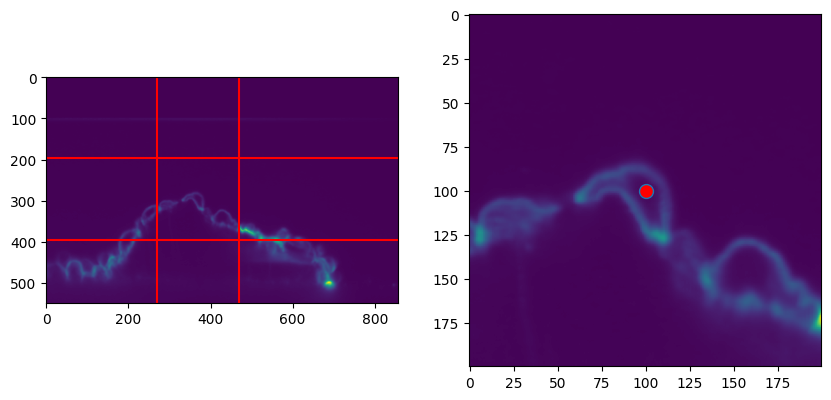

In [61]:
y1 = 300
y2 = 380
x1 = 420
x2 = 500

y1 = 195
y2 = 395
x1 = 270
x2 = 470

z1 = 75
z2 = 140

z = 293
im = image[z][y1:y2, x1:x2]

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.axhline(y1, c='r')
plt.axhline(y2, c='r')
plt.axvline(x1, c='r')
plt.axvline(x2, c='r')
plt.imshow(image[z])
plt.subplot(122)
plt.imshow(im)
# 135, 142
plt.plot((y2-y1)/2, (x2-x1)/2, marker="o", markersize=10, markerfacecolor="red")

In [62]:
from cellpose import models, io
model = models.Cellpose(gpu=False, model_type='cyto')
channels = [0,0] # There is no nucleus, the image is GRAYSCALE. First number would be the channel for the cytoplasm and the second for the nucleus
masks, flows, styles, diams = model.eval(im, diameter=None, channels=channels)


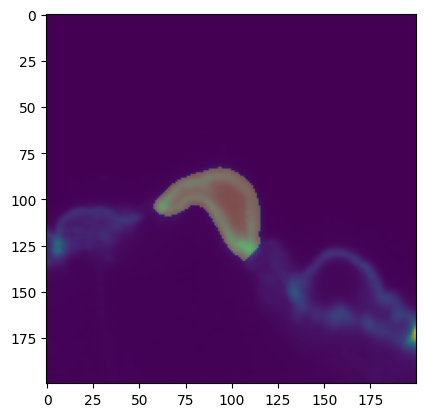

In [63]:
mask = np.where(masks == 1, masks, 0)
plt.imshow(mask)
plt.imshow(im, alpha=0.7)

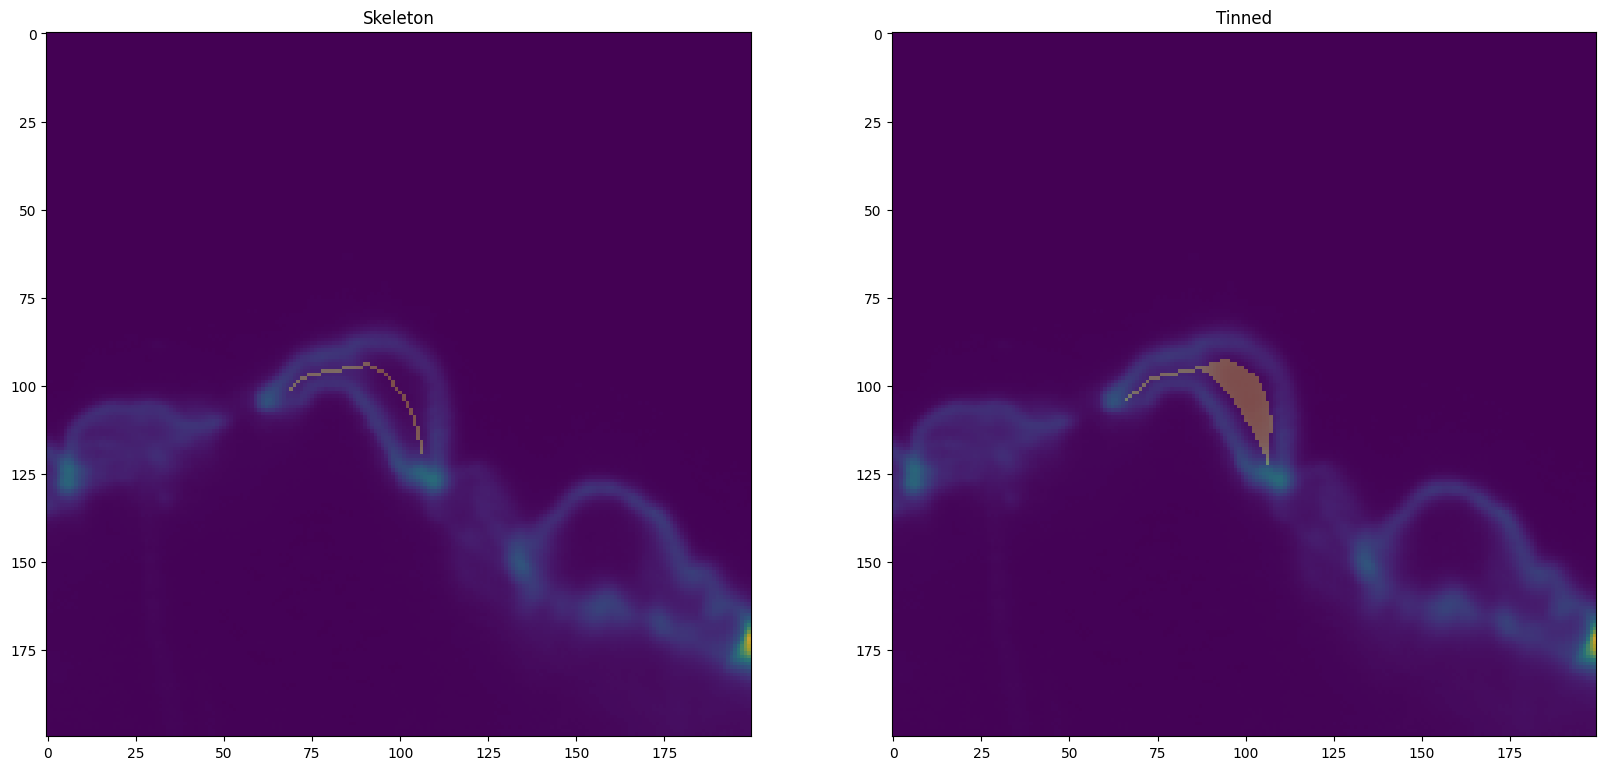

In [254]:
skeleton = skeletonize(cv2.erode(mask, kernel=np.ones((11, 11))))
thinned = thin(cv2.erode(mask, kernel=np.ones((10,10))), max_num_iter=4)
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(skeleton)
plt.title('Skeleton')
plt.imshow(im, alpha=0.7)
plt.subplot(122)
plt.imshow(thinned)
plt.imshow(im, alpha=0.7)
plt.title('Tinned');

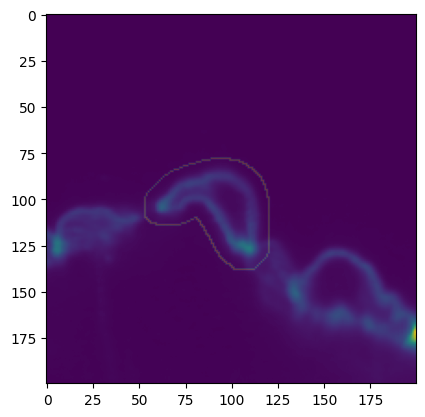

In [255]:
mask_dilated = cv2.dilate(mask, kernel=np.ones((10, 10)))
mask_contour = sk.measure.find_contours(mask_dilated)[0]

mask_border = np.zeros(mask_dilated.shape)

for i in mask_contour:
    mask_border[int(i[0]), int(i[1])] = 1

plt.imshow(im)
plt.imshow(mask_border, alpha=0.2)

240


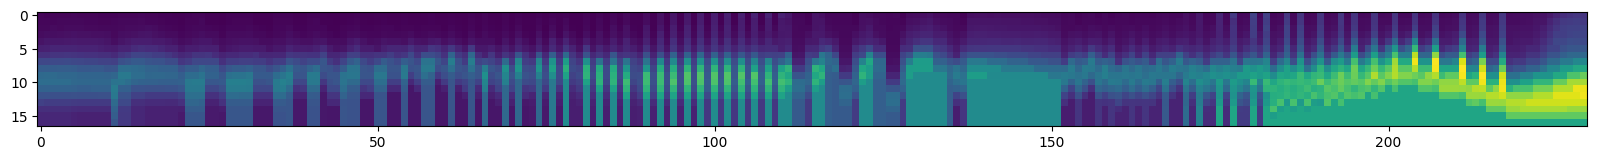

In [285]:
mask_border_coords = np.transpose(np.where(mask_border != 0))
mask_skeleton_coords = np.transpose(np.where(thinned != 0))
print(len(mask_skeleton_coords))

def bresenham_line(x1, y1, x2, y2):
    points = []

    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    error = dx - dy
    x, y = x1, y1

    while True:
        points.append((x, y))
        if x == x2 and y == y2:
            break
        e2 = 2 * error
        if e2 > -dy:
            error -= dy
            x += sx

        if e2 < dx:
            error += dx
            y += sy

    return points


lines = []

for border in mask_border_coords:
    distances = np.linalg.norm(mask_skeleton_coords - border, axis=1)
    closest_index = np.argmin(distances)
    closest_point = mask_skeleton_coords[closest_index]
    
    line = bresenham_line(*border, *closest_point)
    
    lines.append(line)
   
 
max_line = max(lines, key=len)
intensities = np.zeros((len(max_line), len(lines)))

for x, line in enumerate(lines):
    while len(line) < len(max_line): # add coords
        line.append(line[-1])
    
    for y, coord in enumerate(line):
       intensities[y, x] = im[coord[0], coord[1]]
        
plt.figure(figsize=(20,20))
plt.imshow(intensities)


(17, 230)


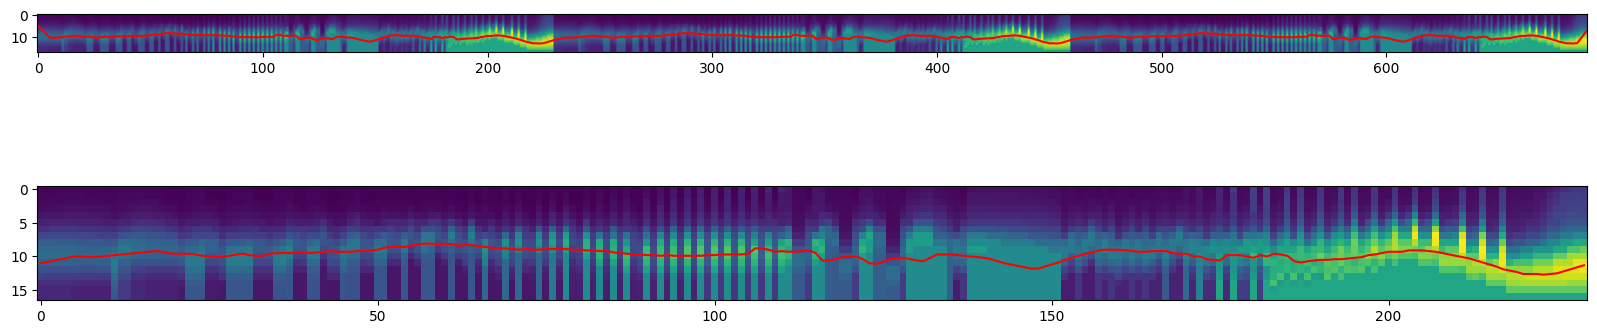

In [283]:
def smooth_array(arr, window_size):
    kernel = np.ones(window_size) / window_size
    smoothed_arr = np.convolve(arr, kernel, mode='same')
    return smoothed_arr

cell_border = []

plt.figure(figsize=(20, 5))

for i in range(intensities.shape[1]):
    x = np.linspace(0, 1, len(intensities[:,i]))
    y = intensities[:,i]
    
    window_size = 5
    y = smooth_array(y, window_size)
    
    dy_dx = np.diff(y) / np.diff(x)
    #plt.plot(y)
    
    # Find the indices of relative maxima
    maxima_indices = argrelextrema(y, np.greater) # Just the maxima.
    
     
    peaks, peak_plateaus = find_peaks(y, plateau_size = 1) # Plateau
    for i in range(len(peak_plateaus['plateau_sizes'])):
        if peak_plateaus['plateau_sizes'][i] > 1:
            peak_plateaus['left_edges'][i]
    
    
    if len(maxima_indices[0]) == 0:
        first_local_max_index = peak_plateaus['left_edges'][i] # If there is no maxima add the plateau
    else:
        first_local_max_index = maxima_indices[0][0] # Get the index of the first local maximum
    
    cell_border.append(first_local_max_index)


print(intensities.shape)
smooth_border = smooth_array(np.tile(cell_border, 3),10)
plt.subplot(211)
plt.imshow(np.tile(intensities, 3))
plt.plot(smooth_border, color='r')
plt.subplot(212)
middle_image = np.tile(intensities, 3)[:, intensities.shape[1]:intensities.shape[1]*2]
middle_border = smooth_border[intensities.shape[1]:intensities.shape[1]*2]
plt.imshow(middle_image)
plt.plot(middle_border, color='r');

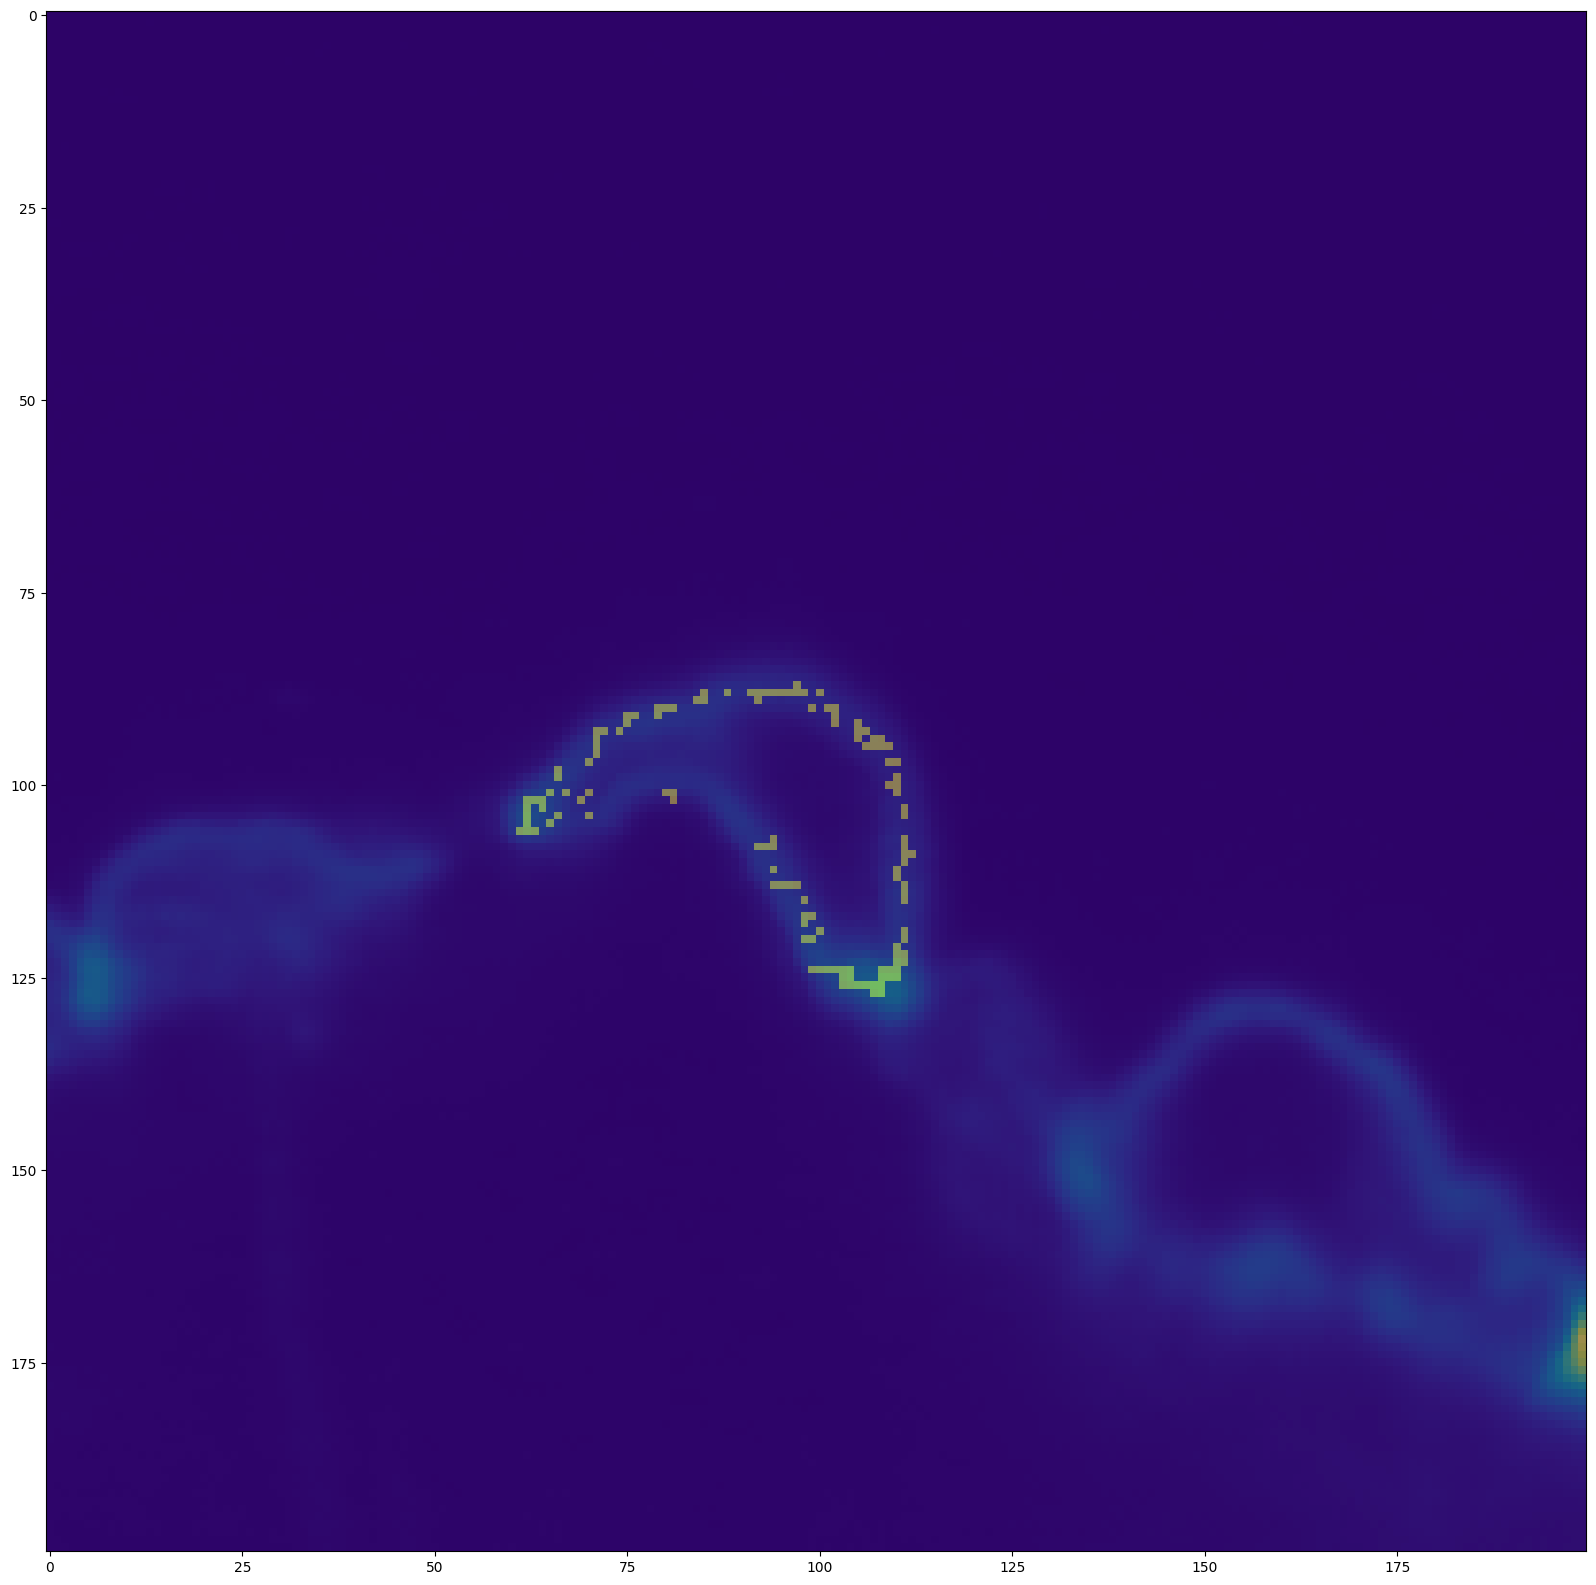

In [284]:
intensities_cartesian = np.zeros(im.shape)

for r, coord in zip(middle_border, lines):
    intensities_cartesian[*coord[int(r)]] = 1

plt.figure(figsize=(20,20))
plt.imshow(im)
plt.imshow(intensities_cartesian, alpha=0.4, cmap='plasma');


